Librerías

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

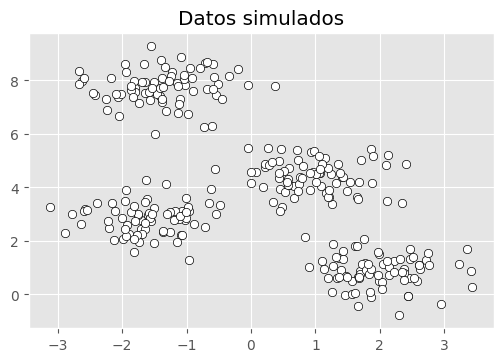

In [2]:
# Simulación de datos
# ==============================================================================
X, y = make_blobs(
        n_samples    = 300, 
        n_features   = 2, 
        centers      = 4, 
        cluster_std  = 0.60, 
        shuffle      = True, 
        random_state = 0
       )

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.scatter(
    x = X[:, 0],
    y = X[:, 1], 
    c = 'white',
    marker    = 'o',
    edgecolor = 'black', 
)
ax.set_title('Datos simulados');

Modelo Kmeans

Con la clase sklearn.cluster.KMeans de Scikit-Learn se pueden entrenar modelos de clustering utilizando el algoritmo k-means. Entre sus parámetros destacan:

n_clusters: determina el número  K
  de clusters que se van a generar.

init: estrategia para asignar los centroides iniciales. Por defecto se emplea 'k-means++', una estrategia que trata de alejar los centroides lo máximo posible facilitando la convergencia. Sin embargo, esta estrategia puede ralentizar el proceso cuando hay muchos datos, si esto ocurre, es mejor utilizar 'random'.

n_init: determina el número de veces que se va a repetir el proceso, cada vez con una asignación aleatoria inicial distinta. Es recomendable que este último valor sea alto, entre 10-25, para no obtener resultados subóptimos debido a una iniciación poco afortunada del proceso.

max_iter: número máximo de iteraciones permitidas.

random_state: semilla para garantizar la reproducibilidad de los resultados.

In [3]:
# Escalado de datos
# ==============================================================================
X_scaled = scale(X)

In [4]:
# Modelo
# ==============================================================================
X_scaled = scale(X)
modelo_kmeans = KMeans(n_clusters=4, n_init=25, random_state=123)
modelo_kmeans.fit(X=X_scaled)

KMeans(n_clusters=4, n_init=25, random_state=123)

In [5]:
# Clasificación con el modelo kmeans
# ==============================================================================
y_predict = modelo_kmeans.predict(X=X_scaled)

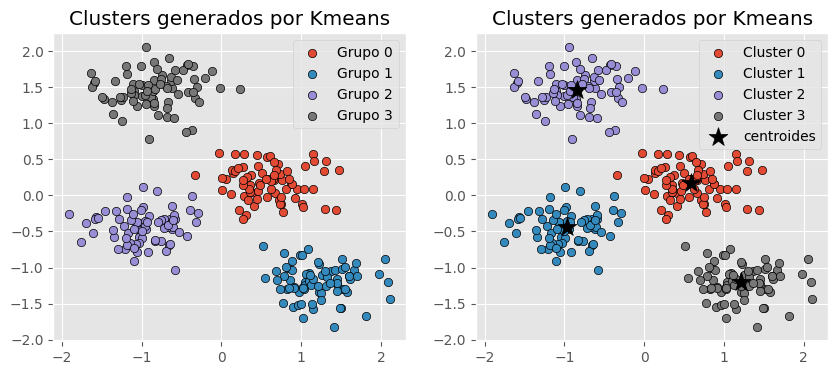

In [6]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Grupo {i}"
    )
    
ax[0].set_title('Clusters generados por Kmeans')
ax[0].legend();

for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Cluster {i}"
    )
    
ax[1].scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1], 
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend();

Este tipo de visualización es muy útil e informativa, sin embargo, solo es posible cuando se trabaja con dos dimensiones. Si los datos contienen más de dos variables (dimensiones), una posible solución es utilizar las dos primeras componentes principales obtenidas con un PCA previo.

In [7]:
# Matriz de confusión: grupos originales vs clusters creados
# ==============================================================================
pd.crosstab(y, y_predict, dropna=False, rownames=['grupo_real'], colnames=['cluster'])

cluster,0,1,2,3
grupo_real,,,,
0,75,0,0,0
1,0,0,0,75
2,0,75,0,0
3,0,0,75,0


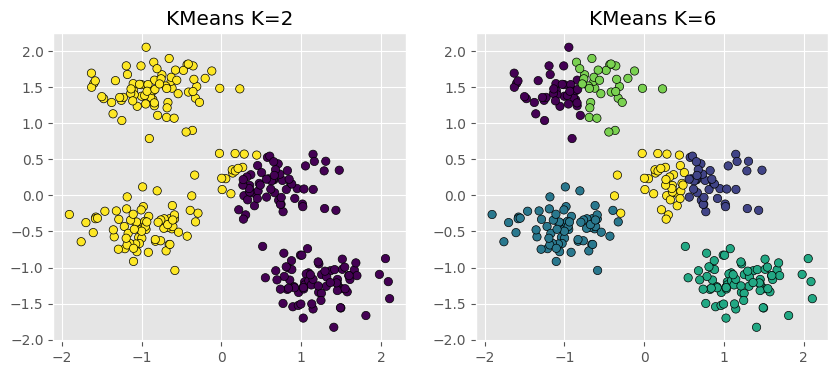

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Resultados para K = 2
# ==============================================================================
y_predict = KMeans(n_clusters=2, n_init=25, random_state=123).fit_predict(X=X_scaled)
ax[0].scatter(
        x = X_scaled[:, 0],
        y = X_scaled[:, 1], 
        c = y_predict,
        #cmap='viridis',
        marker    = 'o',
        edgecolor = 'black'
    )
ax[0].set_title('KMeans K=2');

# Resultados para K = 6
# ==============================================================================
y_predict = KMeans(n_clusters=6, n_init=25, random_state=123).fit_predict(X=X_scaled)
ax[1].scatter(
        x = X_scaled[:, 0],
        y = X_scaled[:, 1], 
        c = y_predict,
        #cmap='viridis',
        marker    = 'o',
        edgecolor = 'black'
    )
ax[1].set_title('KMeans K=6');

Al observar los resultados obtenidos para K = 2, es intuitivo pensar que el grupo que se encuentra entorno a las coordenadas  x=0.5,y=0
  (mayoritariamente considerado como amarillo) debería ser un grupo separado. Para K = 6 no parece muy razonable la separación de los grupos amarillo y azul. Este ejemplo muestra la principal limitación del método de K-means, el hecho de tener que escoger de antemano el número de clusters que se generan.

La deducción anterior solo puede hacerse visualmente cuando se trata de dos dimensiones. Una forma sencilla de estimar el número K óptimo de clusters cuando no se dispone de esta información, es aplicar el algoritmo de K-means para un rango de valores de K e identificar aquel valor a partir del cual la reducción en la suma total de varianza intra-cluster (inertia) deja de ser sustancial. A esta estrategia se la conoce como método del codo o elbow method.

ENCONTRAR CLUSTER OPTIMO

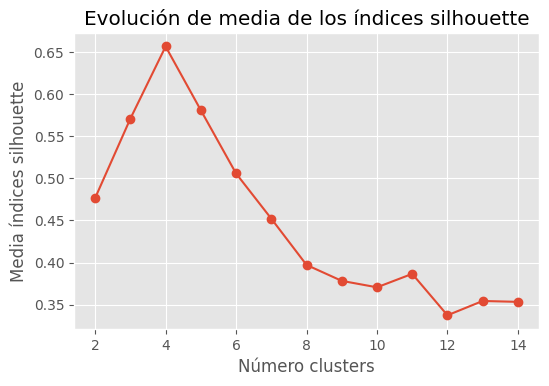

In [9]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    cluster_labels = modelo_kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)
    
fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

El valor medio de los índices silhouette se maximiza con 4 clusters. Acorde a este criterio, K = 4 es la mejor opción.